# Multiclass Classification

In [57]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

def label_bcva(row): 
    final_bcva = row.target_va
    toRtn = 0
    if final_bcva < 60: 
        if final_bcva < 40: toRtn = 0
        else: toRtn = 1
    else:
        if final_bcva < 80: toRtn = 2
        else: toRtn = 3
    return toRtn

df = pd.read_csv("~/Documents/Github/paper/input/df_3_years.csv")
df['outcome'] = df.apply(lambda row: label_bcva(row), axis=1)

X, y = df.drop(columns=['target_va', 'outcome']), df.outcome.values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=4)

def score(model, X, y, cv=5, scoring='accuracy'):
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    return np.mean(scores), np.std(scores)

In [2]:
# baseline
def label_bcva(row): 
    final_bcva = row.va_4
    toRtn = 0
    if final_bcva < 60: 
        if final_bcva < 40: toRtn = 0
        else: toRtn = 1
    else:
        if final_bcva < 80: toRtn = 2
        else: toRtn = 3
    return toRtn

preds = X.apply(lambda row: label_bcva(row), axis=1).values
accuracy_score(preds, y)

0.583547557840617

## Logistic regression

In [3]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
score(lr, X, y)

(0.4652347652347652, 0.02068288631751248)

In [4]:
lr.fit(X_train, y_train)
preds = lr.predict(X_valid)
accuracy_score(y_valid, preds)

0.47435897435897434

In [5]:
lr.fit(X_train, y_train)
preds = lr.predict_proba(X_valid)
roc_auc_score(y_valid, preds, average="weighted", multi_class="ovr")

0.7148094062799946

## Random forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
score(rf, X, y)

(0.5886113886113886, 0.05731277234757068)

In [15]:
rf.fit(X_train, y_train)
preds = rf.predict(X_valid)
accuracy_score(y_valid, preds)

0.5641025641025641

In [16]:
rf.fit(X_train, y_train)
preds = rf.predict_proba(X_valid)
roc_auc_score(y_valid, preds, average="weighted", multi_class="ovr")

0.7987591983180218

In [17]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       )
rf.fit(X, y)
fi = rf_feat_importance(rf, X)
fi

,cols,imp
0,va_1,0.055546
1,irf_1,0.019667
2,srf_1,0.033656
3,va_2,0.065551
4,irf_2,0.022166
5,srf_2,0.036677
6,int_2,0.065153
7,va_3,0.077042
8,irf_3,0.021772
9,srf_3,0.032622


In [20]:
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import PartialDependenceDisplay

features = ['first_va', 'mean_vision', 'std_vision']
PartialDependenceDisplay.from_estimator(rf, X, features, kind='individual')

display = PartialDependenceDisplay.from_estimator(
    rf,
    X,
    features,
    kind="both",
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
)
display.figure_.suptitle(
    "Partial dependence of target VA", size=20
)
display.figure_.subplots_adjust(hspace=0.3)
display.figure_.savefig("partial_dependence.png", dpi=250)

ValueError: target must be specified for multi-class

## Gradient boosted classifier

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
score(gb, X, y)

(0.7250749250749251, 0.04025564984934498)

In [21]:
gb.fit(X_train, y_train)
preds = gb.predict(X_valid)
accuracy_score(y_valid, preds)

0.7692307692307693

In [22]:
gb.fit(X_train, y_train)
preds = gb.predict_proba(X_test)
roc_auc_score(y_test, preds, average="weighted", multi_class="ovr")

0.9369237625119978

## TabNet

In [6]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
np.random.seed(0)

from matplotlib import pyplot as plt
%matplotlib inline

X, y = df.drop(columns=['target_va', 'outcome']).values, df.outcome.values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=4)

In [7]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15,
    verbose=0
)

In [8]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=1000, patience=100,
    batch_size=64
) 


Early stopping occurred at epoch 189 with best_epoch = 89 and best_valid_accuracy = 0.65385
Best weights from best epoch are automatically used!


In [9]:
preds = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds, y_true=y_valid,
                          average="weighted", multi_class="ovr")
valid_auc

0.821765620000914

In [10]:
preds = clf.predict(X_valid)
accuracy_score(y_valid, preds)

0.6538461538461539

In [11]:
clf.feature_importances_

array([3.37762714e-02, 0.00000000e+00, 9.46332769e-05, 2.28187263e-01,
       6.35487301e-02, 4.30121391e-02, 9.66689465e-04, 8.47606095e-02,
       4.51645572e-02, 0.00000000e+00, 0.00000000e+00, 1.43125310e-01,
       5.38099565e-02, 4.55494864e-03, 2.79484067e-03, 1.45773819e-02,
       2.81626669e-01])

In [12]:
X = df.drop(columns=['target_va', 'outcome'])
cols = X.columns
cols

Index(['va_1', 'irf_1', 'srf_1', 'va_2', 'irf_2', 'srf_2', 'int_2', 'va_3',
       'irf_3', 'srf_3', 'int_3', 'va_4', 'irf_4', 'srf_4', 'int_4',
       'mean_vision', 'std_vision'],
      dtype='object')

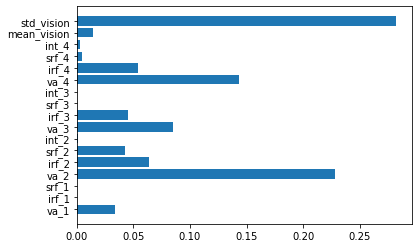

In [13]:
plt.barh(cols, clf.feature_importances_);

# Probability distributions

## Single-year BCVA distribution

In [21]:
import os 
os.chdir('/Users/charlesoneill/Documents/GitHub/paper/results')

In [55]:
def return_tabnet():
    return TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15,
    verbose=0)

In [64]:
def train_tabnet(year):
    df = pd.read_csv(f"~/Documents/Github/paper/input/df_{year}_years.csv")
    df['outcome'] = df.apply(lambda row: label_bcva(row), axis=1)
    X, y = df.drop(columns=['target_va', 'outcome']).values, df.outcome.values
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=4)
    clf = return_tabnet()
    clf.fit(X_train=X_train, y_train=y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            eval_name=['train', 'valid'], max_epochs=1000, patience=100,
            batch_size=64)
    return clf

In [65]:
clf_1 = train_tabnet(1)
clf_2 = train_tabnet(2)
clf_3 = train_tabnet(3)
model_lst = [clf_1, clf_2, clf_3]


Early stopping occurred at epoch 182 with best_epoch = 82 and best_valid_accuracy = 0.72
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 202 with best_epoch = 102 and best_valid_accuracy = 0.68085
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 189 with best_epoch = 89 and best_valid_accuracy = 0.65385
Best weights from best epoch are automatically used!


In [68]:
def bcva_prob_dist(model, sample, year, ground_truth):
    t = [0, 30, 50, 70, 90, 100]
    preds_proba = model.predict_proba(sample).tolist()[0]
    preds_proba.insert(0, 0.0)
    preds_proba.append(0)
    plt.plot(t, preds_proba, color="orange")
    plt.fill_between(t, preds_proba, color="navy")
    plt.axvline(x=ground_truth, color='r', linestyle='-', label="True vision")
    plt.ylabel("Probability of BCVA")
    plt.xlabel(f"Vision at end of Year {year} (logMAR letters)")
    plt.legend()
    plt.savefig(f"year{year}_patient_distribution.png", dpi=300)
    plt.show()

In [70]:
sample = X_valid[1:2]
bcva_prob_dist(clf_1, sample, 3, 40)

KeyError: 0

In [71]:
def get_three_years(patient_id, model_lst, plot=True):
    preds = []
    for i in range(1, 4):
        df = pd.read_csv(f"~/Documents/Github/paper/input/df_{i}_years.csv")
        df['outcome'] = df.apply(lambda row: label_bcva(row), axis=1)
        X = df.drop(columns=['target_va', 'outcome']).iloc[patient_id].values
        y = df.outcome.iloc[patient_id]
        ground_truth = df.target_va.iloc[patient_id]
        if plot: bcva_prob_dist(model_lst[i-1], [X], i, ground_truth)
        preds.append(model_lst[i-1].predict_proba([X]).tolist()[0])
    if not plot: return preds

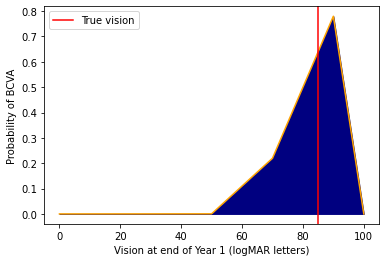

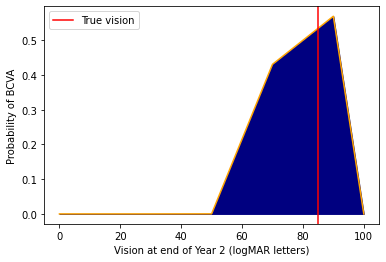

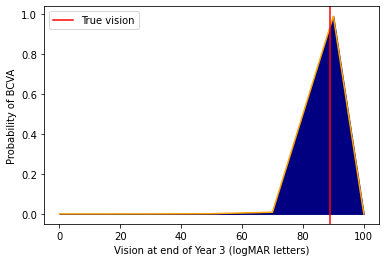

In [72]:
get_three_years(12, model_lst)

## Temporal BCVA distributions

In [85]:
preds = get_three_years(11, model_lst, plot=False)
preds

[[0.0005350853316485882,
  0.001638788846321404,
  0.37912705540657043,
  0.6186990141868591],
 [3.75551862816792e-05,
  0.00010069409472635016,
  0.23822419345378876,
  0.7616376280784607],
 [1.3372237845032942e-05,
  0.000156654670718126,
  0.8583002686500549,
  0.1415296196937561]]

In [86]:
def prob_to_vision(index): return 30 + (index*20)

def preds_to_scalar(preds): 
    toRtn = 0
    for i in range(3):
        toRtn += prob_to_vision(i) * preds[i]
    return toRtn

In [87]:
preds

[[0.0005350853316485882,
  0.001638788846321404,
  0.37912705540657043,
  0.6186990141868591],
 [3.75551862816792e-05,
  0.00010069409472635016,
  0.23822419345378876,
  0.7616376280784607],
 [1.3372237845032942e-05,
  0.000156654670718126,
  0.8583002686500549,
  0.1415296196937561]]

In [88]:
def prob(scalar): return np.round(scalar*100)

def temporal_prob_dist(preds):
    y_40, y_60, y_80, y_100 = [], [], [], [] 
    for i in range(3):
        y_40.append(prob(preds[i][0])), y_60.append(prob(preds[i][1]))
        y_80.append(prob(preds[i][2])), y_100.append(prob(preds[i][3]))
    df_plot = pd.DataFrame({"Below 40": y_40, "40-60": y_60,
                            "60-80": y_80, "80-100": y_100})
    df_plot[["Below 40", "40-60", "60-80", "80-100"]].plot(kind="bar", width = .35)
    ax = plt.gca()
    ax.set_xticklabels(("Year 1", "Year 2", "Year 3"))
    ax.set_ylabel("Probability of BCVA (%)")
    plt.savefig("temporal_patient_prob.png", dpi=300)
    plt.show()
    return df_plot

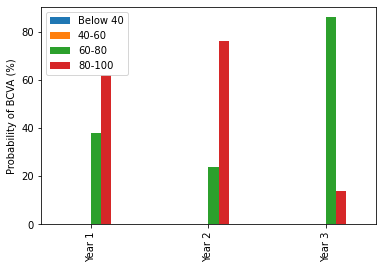

In [89]:
df_plot = temporal_prob_dist(preds)

In [90]:
t = df_plot.iloc[2].values

def expected_value(t):
    total = 0
    for i in range(0, 40): total += t[0]/40 * i
    for i in range(40, 60): total += t[1]/20 * i
    for i in range(60, 80): total += t[2]/20 * i
    for i in range(80, 100): total += t[3]/20 * i
    return total/100

expected_value(t)

72.3

In [91]:
def expected_value(t):
    total = 0
    total += (20 * t[0]) + (50 * t[1]) + (70 * t[2]) + (90 * t[3])
    return total/100

def expected_value_plot(df_plot):
    toRtn = []
    for i in range(3):
        t = df_plot.iloc[i].values
        ev = expected_value(t)
        toRtn.append(ev)
    return toRtn

In [92]:
expected_value_plot(df_plot)

[82.4, 85.2, 72.8]

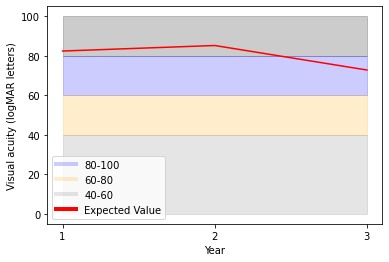

In [93]:
import matplotlib.pyplot as plt

# Data
x =  [1, 2, 3]
y0 = df_plot['Below 40'].values
y1 = df_plot['40-60'].values
y2 = df_plot['60-80'].values
y3 = df_plot['80-100'].values

# Shade the area between y1 and y2
plt.fill_between(x, 100, 80, color="black", alpha=0.2)
plt.fill_between(x, 80, 60,
                 facecolor="orange", # the fill color
                 color='blue',       # the outline color
                 alpha=0.2)          # transparency of the fill
plt.fill_between(x, 60, 40, color="orange", alpha=0.2)
plt.fill_between(x, 40, 0, color="gray", alpha=0.2)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="blue", lw=4, alpha=0.2),
                Line2D([0], [0], color="orange", lw=4, alpha=0.2),
                Line2D([0], [0], color="gray", lw=4, alpha=0.2),
                Line2D([0], [0], color='red', lw=4)]
plt.plot(x, expected_value_plot(df_plot), color='red')

plt.legend(custom_lines, ['80-100', '60-80', '40-60', 'Expected Value'])
plt.ylabel("Visual acuity (logMAR letters)")
plt.xlabel("Year")
plt.xticks([1,2,3], ["1", "2", "3"])
plt.savefig("cumulative_prob.png", dpi=300)
plt.show()

## MLP

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
import torch.nn as nn
import torch
from torch.autograd import Variable
import torch.nn.functional as F

In [65]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(18, 32)
        self.fc2 = nn.Linear(32, 16)
        self.out = nn.Linear(16, 4)
        self.dropout = nn.Dropout(p=0)
        self.batchnorm1 = nn.BatchNorm1d(18)
        self.batchnorm2 = nn.BatchNorm1d(32)
    
    def forward(self, x):
        x = self.dropout(torch.relu(self.fc1(self.batchnorm1(x))))
        x = self.dropout(torch.relu(self.fc2(self.batchnorm2(x))))    
        output = torch.tanh(self.out(x))
        return output

In [66]:
class PytorchKfolds:
    
    def __init__(self, n_epochs=30):
        self.df = self.init_df()
        self.kdf = self.create_folds(self.df)
        self.n_epochs = n_epochs
        self.loss_fn = nn.CrossEntropyLoss()

    def init_df(self):
        def label_bcva(row): 
            final_bcva = row.target_va
            toRtn = 0
            if final_bcva < 60: 
                if final_bcva < 40: toRtn = 0
                else: toRtn = 1
            else:
                if final_bcva < 80: toRtn = 2
                else: toRtn = 3
            return toRtn
        df = pd.read_csv("~/Documents/Github/paper/input/df_1_years.csv")
        df['outcome'] = df.apply(lambda row: label_bcva(row), axis=1)
        return df
    
    def create_folds(self, df):
        # we create a new column called kfold and fill it with -1
        df["kfold"] = -1
        # the next step is to randomize the rows of the data
        df = df.sample(frac=1).reset_index(drop=True)
        # fetch labels
        y = df.outcome.values
        # initiate the kfold class from model_selection module
        kf = model_selection.StratifiedKFold(n_splits=5)
        # fill the new kfold column
        for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
            df.loc[v_, 'kfold'] = f
        return df
    
    def inputs_targets(self, df, fold):
        df = self.create_folds(df)
        df_train = df[df.kfold != fold].reset_index(drop=True)
        df_train.fillna(df_train.mean(), inplace=True)
        df_valid = df[df.kfold == fold].reset_index(drop=True)
        df_valid.fillna(df_valid.mean(), inplace=True)
        X_train = df_train.drop(columns=["target_va", "outcome", "kfold"]).values
        y_train = df_train.outcome.values
        X_valid = df_valid.drop(columns=["target_va", "outcome", "kfold"]).values
        y_valid = df_valid.outcome.values
        return X_train, X_valid, y_train, y_valid
    
    def train_test_kfold(self, df, fold):
        X_train, X_test, y_train, y_test = self.inputs_targets(df, fold)
        # scale the data
        ss = StandardScaler()
        X_train, X_test = ss.fit_transform(X_train), ss.fit_transform(X_test)
        # convert to tensors
        X_train_tensors = Variable(torch.Tensor(X_train))
        X_test_tensors = Variable(torch.Tensor(X_test))
        y_train_tensors = Variable(torch.Tensor(y_train))
        y_test_tensors = Variable(torch.Tensor(y_test))
        return X_train_tensors, X_test_tensors, y_train_tensors, y_test_tensors
    
    def create_dataloaders(self, X_train, X_test, y_train, y_test):
        train_data, test_data = [], []
        for i in range(len(X_train)):
            train_data.append([X_train[i].to(torch.float32), 
                               y_train[i].type(torch.LongTensor)])
        for i in range(len(X_test)):
            test_data.append([X_test[i].to(torch.float32), 
                               y_test[i].type(torch.LongTensor)])
        train_loader = torch.utils.data.DataLoader(train_data, shuffle=False, 
                                               batch_size=64, drop_last=True)
        test_loader = torch.utils.data.DataLoader(test_data, shuffle=False, 
                                                  batch_size=len(X_test))
        return train_loader, test_loader
    
    def reset_weights(self, m):
        for layer in m.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
    
    def accuracy_score(self, val_loader, model):
        model.eval()
        correct, total = 0, 0
        with torch.no_grad(): # we don't want gradients here
            for imgs, labels in val_loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
            return correct/total
        
    def auc_score(self, val_loader, model):
        model.eval()
        aucs = []
        with torch.no_grad():
            for imgs, labels in val_loader:
                outputs = model(imgs).detach().numpy()
                labels = labels.detach().numpy()
                aucs.append(roc_auc_score(labels, outputs[0], average="weighted",
                                          multi_class='ovr'))
            return np.round(np.mean(aucs), 4)
                
    
    def training_loop(self, train_loader, val_loader, verbose=0):
        n_epochs=self.n_epochs
        model=Net()
        model.apply(self.reset_weights)
        optimiser=torch.optim.Adam(model.parameters(), lr=1e-2)
        loss_fn=self.loss_fn
        model.train()
        for epoch in range(1, n_epochs + 1):
            loss_train, loss_test = 0.0, 0.0
            for imgs, labels in train_loader:
                b_x = Variable(imgs)   # batch x
                b_y = Variable(labels)   # batch y
                outputs = model(imgs)
                loss = loss_fn(outputs, b_y)
                optimiser.zero_grad()
                loss.backward()
                optimiser.step()
                loss_train += loss.item() # .item() is used to escape gradient
            accuracy = self.accuracy_score(val_loader, model)
            if (epoch == 1 or epoch % (n_epochs/10) == 0) and verbose>0:
                print("Epoch {}, Training Loss {}, Accuracy {}%".format(
                    epoch,
                    np.round(loss_train / len(train_loader), 4),
                    np.round(accuracy*100, 2)))
        train_accuracy = self.accuracy_score(train_loader, model)
        test_accuracy = self.accuracy_score(val_loader, model)
        test_auc = self.auc_score(val_loader, model)
        if verbose==1:
            print(f"Train accuracy = {train_accuracy*100}%, validation accuracy = {test_accuracy*100}%")
            print(f"Test ROC AUC = {test_auc}")
        return train_accuracy, test_accuracy, test_auc
                
    def kfold_train(self, verbose=0):
        tr_a, te_a, te_auc = [], [], []
        for i in range(5):
            if verbose > 0: print(f'FOLD {i}')
            X_train, X_test, y_train, y_test = self.train_test_kfold(self.kdf, i)
            train_loader, val_loader = self.create_dataloaders(X_train, X_test, y_train, y_test)
            train_acc, test_acc, test_auc = self.training_loop(train_loader=train_loader, 
                                                     val_loader=val_loader, verbose=verbose)
            tr_a.append(np.round(train_acc, 2))
            te_a.append(np.round(test_acc, 2))
            te_auc.append(np.round(test_auc, 2))
            if verbose > 0: print('--------------------------------')
        if verbose!=-1:
            print("FINAL RESULTS")
            print(f"Mean training accuracy: {round(np.mean(tr_a), 2)} (+/- {round(np.std(tr_a), 2)})")
            print(f"Mean validation accuracy: {round(np.mean(te_a), 2)} (+/- {round(np.std(te_a), 2)})")
            print(f"Mean validation ROC AUC: {round(np.mean(te_auc), 2)} (+/- {round(np.std(te_auc), 2)})")
        if verbose==-1: return np.mean(te_auc)

In [67]:
ete = PytorchKfolds(n_epochs=40)
trainl, testl = ete.kfold_train()

AxisError: axis 1 is out of bounds for array of dimension 1

In [41]:
ss = StandardScaler()
X_trans = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size=0.2)

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

train_data, test_data = [], []
for i in range(len(X_train)):
    train_data.append([X_train_tensors[i].to(torch.float32), 
                       y_train_tensors[i].type(torch.LongTensor)])
for i in range(len(X_test)):
    test_data.append([X_test_tensors[i].to(torch.float32), 
                       y_test_tensors[i].type(torch.LongTensor)])

train_loader = torch.utils.data.DataLoader(train_data, shuffle=False, 
                                           batch_size=64, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=False, batch_size=64)

# check shape
i1, l1 = next(iter(train_loader))
print(i1.shape)

torch.Size([64, 18])


In [42]:
data, label = next(iter(train_loader))
data = data[0]
data.shape

torch.Size([18])

In [51]:
model = Net()
model.eval()
output = model(data.unsqueeze(0))
output.detach().numpy()[0]

array([ 0.22200005,  0.10221744, -0.05113522,  0.1969758 ], dtype=float32)

In [54]:
import sys
sys.path.append('../')
from pycore.tikzeng import *

# defined your arch
arch = [
    to_head( '..' ),
    to_cor(),
    to_begin(),
    to_Conv("conv1", 512, 64, offset="(0,0,0)", to="(0,0,0)", height=64, depth=64, width=2 ),
    to_Pool("pool1", offset="(0,0,0)", to="(conv1-east)"),
    to_Conv("conv2", 128, 64, offset="(1,0,0)", to="(pool1-east)", height=32, depth=32, width=2 ),
    to_connection( "pool1", "conv2"),
    to_Pool("pool2", offset="(0,0,0)", to="(conv2-east)", height=28, depth=28, width=1),
    to_SoftMax("soft1", 10 ,"(3,0,0)", "(pool1-east)", caption="SOFT"  ),
    to_connection("pool2", "soft1"),
    to_end()
    ]

def main():
    namefile = str(sys.argv[0]).split('.')[0]
    to_generate(arch, namefile + '.tex' )

ModuleNotFoundError: No module named 'pycore.tikzeng'

In [57]:
!cd pyexamples/
!bash ../tikzmake.sh test_simple

zsh:cd:1: no such file or directory: pyexamples/
bash: ../tikzmake.sh: No such file or directory


In [64]:
dir(pycore.models)

['Image',
 'Lease',
 'Network',
 'NetworkPool',
 'Permission',
 'Task',
 'Template',
 'Token',
 'VM',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'base_model',
 'image',
 'lease',
 'network',
 'network_pool',
 'permission',
 'task',
 'template',
 'token',
 'vm']

In [61]:
import pycore